In [1]:
KAGGLE=False

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
import sklearn.preprocessing

from sklearn.pipeline import make_pipeline 
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, StratifiedKFold,KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression


import catboost as cb
from xgboost import XGBRegressor

import pickle
from sklearn.metrics import r2_score

In [3]:
pd.set_option('display.max_rows', 300)
pd.set_option('display.max_columns', 300)

In [4]:
def load_data(tree=None):
    if KAGGLE:
        train = pd.read_csv('data/train.csv')
        test = pd.read_csv('data/test.csv')
        num_train=np.shape(train)[0]
        num_test=np.shape(test)[0]
        alldata=train.append(test, ignore_index=True)
    else:
        alldata=pd.read_csv('./data/Ames_HousePriceLocsDistNoDpl.csv')#, index_col=0) #already cleaned (see work in appendix files)

        #alldata=pd.read_csv('./data/Ames_HousePriceLocs.csv')#, index_col=0) #already cleaned (see work in appendix files)
    return alldata

alldata=load_data()

In [5]:
def label_encode():
    from sklearn import preprocessing
    le = preprocessing.LabelEncoder()
    for column_name in alldata.columns:
        if alldata[column_name].dtype == object:
            #cat_idxs.append(alldata.columns.get_loc(column_name))
            #alldata[column_name] = alldata[column_name].astype(str)
            alldata[column_name] = le.fit_transform(alldata[column_name])
label_encode()

In [6]:
def split_into_train_test(alldata):
    y=alldata['SalePrice']
    X=alldata.drop(['SalePrice'],axis=1)
    #X=alldata.drop(['SalePrice','distToUI'],axis=1)

    from sklearn.model_selection import train_test_split
    if KAGGLE:
        return split_train_test(alldata=alldata,num_train=num_train)
    else:
        return train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = split_into_train_test(alldata) 

In [7]:
X_train.columns

Index(['GrLivArea', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea',
       'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

In [8]:
from catboost import CatBoostRegressor

from_file = CatBoostRegressor()

cbm=from_file.load_model('./models/model_cb_locs_dist_nodpl')

rf=pickle.load(open('./models/model_rf_locs_dist_nodpl', 'rb'))
xgb=pickle.load(open('./models/model_xgb_locs_dist_nodpl', 'rb'))

In [21]:
def blended_preds(X):
    return ((0.05 * rf.predict(X)) + \
            (0.85 * xgb.best_estimator_.predict(X)) + \
            (0.1 * cbm.predict(X))
           )

In [22]:
preds=blended_preds(X_test)

In [23]:
rmse = np.sqrt(mean_squared_error(y_test,preds))
r2=r2_score(y_test, preds)

In [24]:
print(f'RMSE on Test: {rmse}')
print(f'R2 on Test: {r2}')

RMSE on Test: 20066.513634684197
R2 on Test: 0.9319589056522916


The R2 on the Test set is about .93, similar to the R2's of the two strongest predictors.  
Before dropping duplicates, R2 was .95.

In [25]:
full=pd.read_csv('./data/Ames_HousePriceLocsFULL.csv')#, index_col=0) #already cleaned (see work in appendix files)

In [26]:
X_all=X_test
X_all['preds']=preds

In [27]:
new_df = pd.merge(X_all, full,  how='left', left_on=['lats','longs'], right_on = ['lats','longs'])

In [28]:
np.shape(new_df)

(609, 168)

In [29]:
new_df.columns

Index(['GrLivArea_x', 'MSSubClass_x', 'MSZoning_x', 'LotFrontage_x',
       'LotArea_x', 'Street_x', 'Alley_x', 'LotShape_x', 'LandContour_x',
       'Utilities_x',
       ...
       'MiscFeature_y', 'MiscVal_y', 'MoSold_y', 'YrSold_y', 'SaleType_y',
       'SaleCondition_y', 'Full_Addr', 'MA_Ownr1', 'objs', 'coords'],
      dtype='object', length=168)

In [30]:
new_df.head()

,GrLivArea_x,MSSubClass_x,MSZoning_x,LotFrontage_x,LotArea_x,Street_x,Alley_x,LotShape_x,LandContour_x,Utilities_x,LotConfig_x,LandSlope_x,Neighborhood_x,Condition1_x,Condition2_x,BldgType_x,HouseStyle_x,OverallQual_x,OverallCond_x,YearBuilt_x,YearRemodAdd_x,RoofStyle_x,RoofMatl_x,Exterior1st_x,Exterior2nd_x,MasVnrType_x,MasVnrArea_x,ExterQual_x,ExterCond_x,Foundation_x,BsmtQual_x,BsmtCond_x,BsmtExposure_x,BsmtFinType1_x,BsmtFinSF1_x,BsmtFinType2_x,BsmtFinSF2_x,BsmtUnfSF_x,TotalBsmtSF_x,Heating_x,HeatingQC_x,CentralAir_x,Electrical_x,1stFlrSF_x,2ndFlrSF_x,LowQualFinSF_x,BsmtFullBath_x,BsmtHalfBath_x,FullBath_x,HalfBath_x,BedroomAbvGr_x,KitchenAbvGr_x,KitchenQual_x,TotRmsAbvGrd_x,Functional_x,Fireplaces_x,FireplaceQu_x,GarageType_x,GarageYrBlt_x,GarageFinish_x,GarageCars_x,GarageArea_x,GarageQual_x,GarageCond_x,PavedDrive_x,WoodDeckSF_x,OpenPorchSF_x,EnclosedPorch_x,3SsnPorch_x,ScreenPorch_x,PoolArea_x,PoolQC_x,Fence_x,MiscFeature_x,MiscVal_x,MoSold_x,YrSold_x,SaleType_x,SaleCondition_x,lats,longs,MissingLoc,distToUI,preds,GrLivArea_y,SalePrice,MSSubClass_y,MSZoning_y,LotFrontage_y,LotArea_y,Street_y,Alley_y,LotShape_y,LandContour_y,Utilities_y,LotConfig_y,LandSlope_y,Neighborhood_y,Condition1_y,Condition2_y,BldgType_y,HouseStyle_y,OverallQual_y,OverallCond_y,YearBuilt_y,YearRemodAdd_y,RoofStyle_y,RoofMatl_y,Exterior1st_y,Exterior2nd_y,MasVnrType_y,MasVnrArea_y,ExterQual_y,ExterCond_y,Foundation_y,BsmtQual_y,BsmtCond_y,BsmtExposure_y,BsmtFinType1_y,BsmtFinSF1_y,BsmtFinType2_y,BsmtFinSF2_y,BsmtUnfSF_y,TotalBsmtSF_y,Heating_y,HeatingQC_y,CentralAir_y,Electrical_y,1stFlrSF_y,2ndFlrSF_y,LowQualFinSF_y,BsmtFullBath_y,BsmtHalfBath_y,FullBath_y,HalfBath_y,BedroomAbvGr_y,KitchenAbvGr_y,KitchenQual_y,TotRmsAbvGrd_y,Functional_y,Fireplaces_y,FireplaceQu_y,GarageType_y,GarageYrBlt_y,GarageFinish_y,GarageCars_y,GarageArea_y,GarageQual_y,GarageCond_y,PavedDrive_y,WoodDeckSF_y,OpenPorchSF_y,EnclosedPorch_y,3SsnPorch_y,ScreenPorch_y,PoolArea_y,PoolQC_y,Fence_y,MiscFeature_y,MiscVal_y,MoSold_y,YrSold_y,SaleType_y,SaleCondition_y,Full_Addr,MA_Ownr1,objs,coords
0,1196,50,4,67.0,12354,1,0,3,3,0,0,0,7,2,2,0,0,6,8,1920,2000,1,0,13,14,2,0.0,3,4,0,4,1,2,5,0.0,5,0.0,684.0,684.0,1,2,1,3,684,512,0,0.0,0.0,1,0,3,1,2,7,6,0,5,5,2005.0,2,2.0,528.0,4,4,2,0,46,0,0,0,0,4,0,2,800,8,2009,4,4,42.022087,-93.657991,0,0.670646,135765.919101,1196.0,110000.0,50.0,RL,67.0,12354.0,Pave,Grvl,Reg,Lvl,AllPub,Corner,Gtl,Edwards,Norm,Norm,1Fam,1.5Fin,6.0,8.0,1920.0,2000.0,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,TA,TA,BrkTil,TA,Fa,Mn,Unf,0.0,Unf,0.0,684.0,684.0,GasA,Gd,Y,SBrkr,684.0,512.0,0.0,0.0,0.0,1.0,0.0,3.0,1.0,Gd,7.0,Typ,0.0,NaN,Detchd,2005.0,Unf,2.0,528.0,TA,TA,Y,0.0,46.0,0.0,0.0,0.0,0.0,NaN,GdPrv,Shed,800.0,8.0,2009.0,ConLI,Normal,3008 WOOD ST AMES IA 50014,VDZ PROPERTIES LLC,"3008, Wood Street, Union Drive, Ames, Story Co...","(42.02208660424489, -93.65799136533401)"
1,1932,20,4,96.0,12444,1,2,3,3,0,2,0,17,2,2,0,2,8,5,2008,2008,3,0,12,13,3,426.0,0,4,2,0,4,0,2,1336.0,5,0.0,596.0,1932.0,1,0,1,3,1932,0,0,1.0,0.0,2,0,2,1,0,7,6,1,2,1,2008.0,0,3.0,774.0,4,4,2,0,66,0,304,0,0,4,4,4,0,11,2008,6,5,42.061812,-93.658619,0,2.505194,374595.897783,1932.0,394617.0,20.0,RL,96.0,12444.0,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,NridgHt,Norm,Norm,1Fam,1Story,8.0,5.0,2008.0,2008.0,Hip,CompShg,VinylSd,VinylSd,Stone,426.0,Ex,TA,PConc,Ex,TA,Av,GLQ,1336.0,Unf,0.0,596.0,1932.0,GasA,Ex,Y,SBrkr,1932.0,0.0,0.0,1.0,0.0,2.0,0.0,2.0,1.0,Ex,7.0,Typ,1.0,Gd,Attchd,2008.0,Fin,3.0,774.0,TA,TA,Y,0.0,66.0,0.0,304.0,0.0,0.0,NaN,NaN,NaN,0.0,11.0,2008.0,New,Partial,4221 WEMBLEY AVE AMES IA 50014,"THOMAS, BARRY M & ANGELINA M","4221, Wembley Avenue, Northridge Heights, Ames...","(42.06181159183674, -93.65861938775511)"
2,1776,60,4,54.0,9783,1,2,0,3,0,4,0,8,2,2,0,5,6,5,1996,1996,1,0,6,6,2,0.0,3,4,2,2,4,3,5,0.0,5,0.0,821.0,821.0,1,2,1,3,821,955,0,0.0,0.0,2,1,3,1,4,7,6,1,4,3,1996.0,0,2.0,443.0,4,4,2,286,116,0,0,0,0,4,4,4,0,5,2006,9,4,42.061441,-93.635677,0,2.464523,187432.777614,1776.0,202000.0,60.0,RL,54.0,9783.0,Pave,Na

In [31]:
new_df['preds'].head()

0    135765.919101
1    374595.897783
2    187432.777614
3    140558.731597
4    132265.323643
Name: preds, dtype: float64

In [32]:
new_df[['GrLivArea_x','GrLivArea_y']].head()

,GrLivArea_x,GrLivArea_y
0,1196,1196.0
1,1932,1932.0
2,1776,1776.0
3,1510,1510.0
4,1104,1104.0


In [33]:
#Property taxes+maintenance costs+ insurance costs+ miscelaneous fees
costs_per_year=(.015+.02+.006+.01) 

def dist_premium_func(distance):
    if distance<.8:
        return 1.29
    elif distance < 1.3:
        return 1.05
    else:
        return 1

new_df['dist_premium'] = new_df.apply(lambda x: dist_premium_func(x.distToUI),axis=1)


In [34]:
def vac_rate_func(distance):
    if distance<.8:
        return .017
    elif distance < 1.3:
        return .025
    else:
        return .07

new_df['vac_rate'] = new_df.apply(lambda x: vac_rate_func(x.distToUI),axis=1)

In [35]:
new_df['dist_premium']*(new_df.BedroomAbvGr_x)

0      3.87
1      2.00
2      3.00
3      3.87
4      3.00
       ... 
604    2.00
605    3.00
606    3.87
607    3.00
608    3.15
Length: 609, dtype: float64

In [36]:
new_df['noi']=new_df['dist_premium']*(500*12*new_df['BedroomAbvGr_x']*(1-new_df['vac_rate']))-new_df['preds']*costs_per_year

In [37]:
new_df['cap_rate']=new_df['noi']/new_df['preds']

<AxesSubplot:>

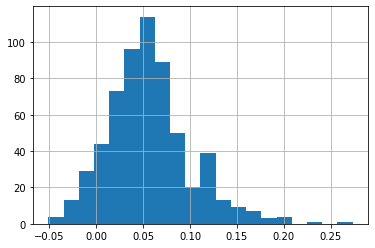

In [38]:
new_df['cap_rate'].hist(bins=20)

In [39]:
new_df.to_csv("./data/test_and_tree_pred_cap_rate.csv",index=False)